# ML-IMC data

## Analysis of ML-IMC training on LJ data

## The data is obtained with my Julia MC code that can be found here:

(https://github.com/mikhail-a-ivanov/ML-IMC)

In [1]:
using Plots
using Statistics
using BSON: @save, @load

include("src/distances.jl")
include("src/readLJ.jl")
include("src/ML-IMC.jl");

# 0. Preparation

In [2]:
HOME = pwd()

"/largedisk/ML-IMC-data"

In [3]:
cd(HOME)

In [4]:
"""
function readloss(outname)

Reads loss data from ML-IMC output file
"""
function readloss(outname)
    lossdata = []
    file = open(outname, "r")
    lines = readlines(file)
    for line in lines
        if length(split(line)) > 0 && split(line)[1] == "Loss"
            append!(lossdata, parse(Float64, split(line)[end]))
        end
    end
    close(file)
    iters = 1:length(lossdata)
    return(iters, lossdata)
end;

In [5]:
"""
histname(rdfname)

Reads distance histogram file produced
by ML-IMC.jl
"""
function readhist(histname)
    file = open(histname, "r")
    println("\nReading histogram data from $(histname)...")
    lines = readlines(file)
    ncomments = 1
    nlines = length(lines) - ncomments
    bins = zeros(nlines)
    hist = zeros(nlines)
    for i in (1 + ncomments):length(lines)
        rdfline = split(lines[i])
        if length(rdfline) == 2
            bins[i - ncomments] = parse(Float64, rdfline[1])
            hist[i - ncomments] = parse(Float64, rdfline[2])
        end
    end
    return(bins, hist)
    close(file)
end;

Reading the reference histogram:

In [6]:
bins, rdfref, histref = readRDF("mcLJ/rdf-mean-p40.dat")
histref ./= 500;


Reading reference data from mcLJ/rdf-mean-p40.dat...


# 1. Training with RDF

In [30]:
cd(HOME * "/RDF_0.0001_0.75")

In [31]:
run(`cat LJML-init.in`)

# System
N             = 1000                 # Number of particles
box           = 36.405 36.405 36.405 # Box vectors [Å]

# Conditions
T             = 95.0                 # [K]

# Monte Carlo parameters          
delta         = 0.75                 # Max displacement [Å]
steps         = 20000000             # Total number of MC steps
Eqsteps       = 10000000             # Equilibration MC steps

# Output control          
xyzout        = 0                    # XYZ output frequency
outfreq       = 1000                 # Output frequency

# RDF parameters          
binWidth      = 0.025                # [Å]
Nbins         = 600                  # Number of bins

# Learning parameters
paircorr      = RDF                  # Type of pair correlations (RDF or histogram)
iters         = 50                   # Number of learning iterations
activation    = identity             # Activation function
optimizer     = Momentum             # Optimizer (other options - Descent)
rate          = 0.0

Process(`cat LJML-init.in`, ProcessExited(0))

In [32]:
itersRDF1, lossdataRDF1 = readloss("ML-IMC.out");

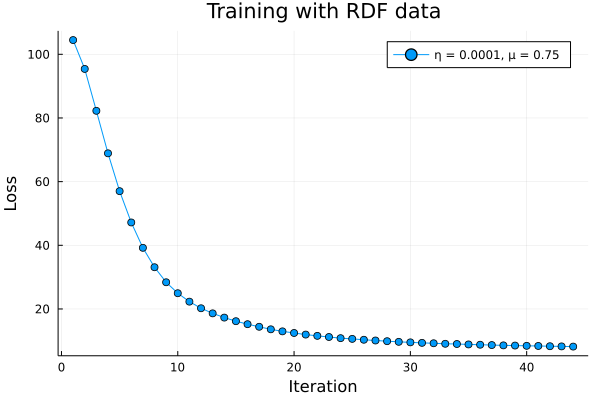

In [33]:
plot(itersRDF1, lossdataRDF1, title="Training with RDF data", label="η = 0.0001, μ = 0.75", marker=(:dot))
xlabel!("Iteration")
ylabel!("Loss")

In [34]:
binsRDF, rdfNN45 = readhist("rdfNN-iter-45.dat");


Reading histogram data from rdfNN-iter-45.dat...


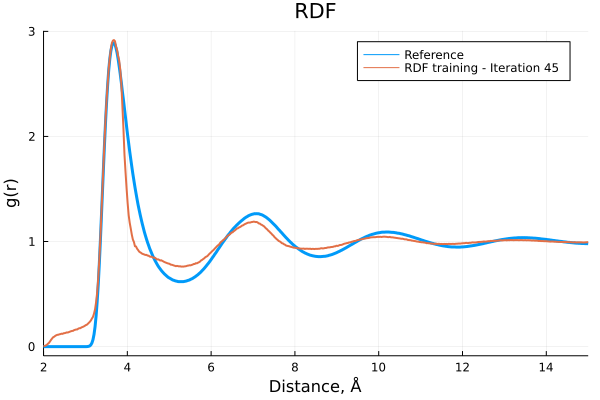

In [35]:
plot(bins, rdfref, xlim = (2, 15), linewidth=3, labels="Reference", title="RDF", legend=:best)
plot!(binsRDF, rdfNN45, xlim = (2, 15), linewidth=2, labels="RDF training - Iteration 45")
xlabel!("Distance, Å")
ylabel!("g(r)")

RDF is very close to convergence! I need to decrease the learning rate or increase friction.

In [36]:
@load "model-iter-45.bson" model
model45 = copy(model.weight');

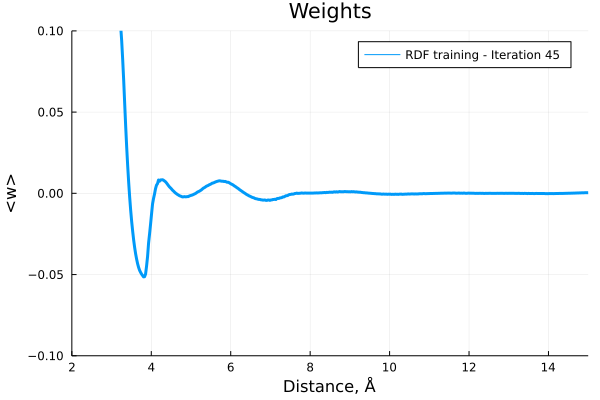

In [39]:
plot(bins, model45, title="Weights", label="RDF training - Iteration 45", xlim=(2, 15), ylim=(-0.1, 0.1), lw=3)
xlabel!("Distance, Å")
ylabel!("<w>")